In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.1+cpu


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

In [4]:
from torch_geometric.datasets import GeometricShapes

dataset = GeometricShapes(root='../../data/geometricshapes')

Extracting ../../data/geometricshapes/raw.zip
Processing...
Done!


In [5]:
print(dataset)

GeometricShapes(40)


In [6]:
data = dataset[0]
print(data)

Data(pos=[32, 3], face=[3, 30], y=[1])


In [ ]:
visualize_mesh(data.pos, data.face)

In [8]:
import torch
from torch_geometric.transforms import SamplePoints

In [9]:
torch.manual_seed(123456)
dataset.transform = SamplePoints(num=256)

data = dataset[0]
print(data)

Data(pos=[256, 3], y=[1])


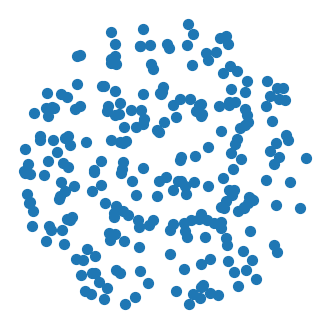

In [10]:
visualize_points(data.pos, data.edge_index)

In [11]:
from torch_cluster import knn_graph
data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)

torch.Size([2, 1536])


In [12]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max')
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)


    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

In [13]:
import torch
import torch.nn.functional as F 
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


In [14]:
class PointNet(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        torch.manual_seed(123456)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)

    def forward(self, pos, batch):
         # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        
        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]
        
        # 5. Classifier.
        return self.classifier(h)

In [15]:
model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)
